<a href="https://colab.research.google.com/github/TimTimich6/investa/blob/main/CRE_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from pathlib import Path
import csv
import datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import sklearn

import tensorflow.keras.backend as K
from tensorflow import GradientTape

from tensorflow.image import resize
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function to return Dataframe having images path, class label and typs
def file_dir_df(root):
  path = []
  label = []
  type = []
  for r, d, f in os.walk(root):
    for file in f:
      if r is not root:
        path.append(r+"/"+file)
        label.append(r.split('/')[1])
        type.append(file.split('.')[1])

  return pd.DataFrame({'path':path,"label":label,"type":type})

In [4]:
df = file_dir_df(r'/content/drive/MyDrive/Colab Notebooks/HackMIT/REI-Dataset')

In [5]:
saved_model_fp = r'/content/drive/MyDrive/Colab Notebooks/HackMIT/saved_models/resnet50v2_2.h5'

In [6]:
df.head()

,path,label,type
0,/content/drive/MyDrive/Colab Notebooks/HackMIT...,content,jpg
1,/content/drive/MyDrive/Colab Notebooks/HackMIT...,content,jpg
2,/content/drive/MyDrive/Colab Notebooks/HackMIT...,content,jpeg
3,/content/drive/MyDrive/Colab Notebooks/HackMIT...,content,jpeg
4,/content/drive/MyDrive/Colab Notebooks/HackMIT...,content,jpeg


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860 entries, 0 to 5859
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    5860 non-null   object
 1   label   5860 non-null   object
 2   type    5860 non-null   object
dtypes: object(3)
memory usage: 137.5+ KB


In [8]:
# because label column kept saying "content" for every image, manually set to correct label (folder name)
for i in range(df.shape[0]):
  df['label'][i] = str(Path(df['path'][i]).parent.absolute())[59:]

bedroom                                     1593
kitchen                                      992
frontyard                                    884
livingRoom                                   852
bathroom                                     793
backyard                                     745
backyard/logs/fits/20230917-032032/train       1
Name: label, dtype: int64

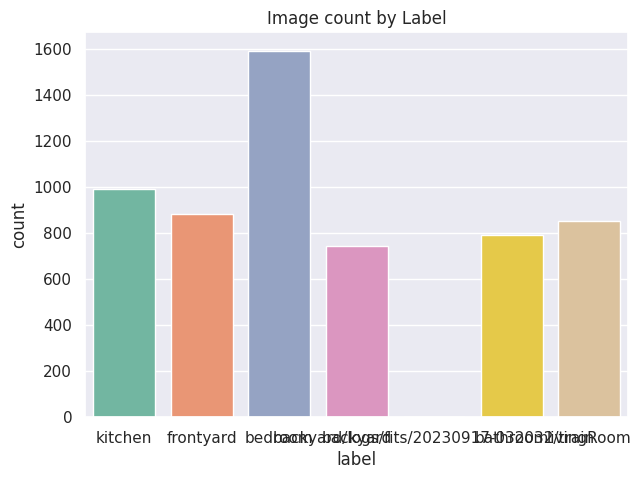

In [9]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
sns.countplot(data =df, x='label',palette="Set2")
plt.title('Image count by Label')
df['label'].value_counts()

jpg     4246
jpeg    1607
png        5
JPG        1
out        1
Name: type, dtype: int64

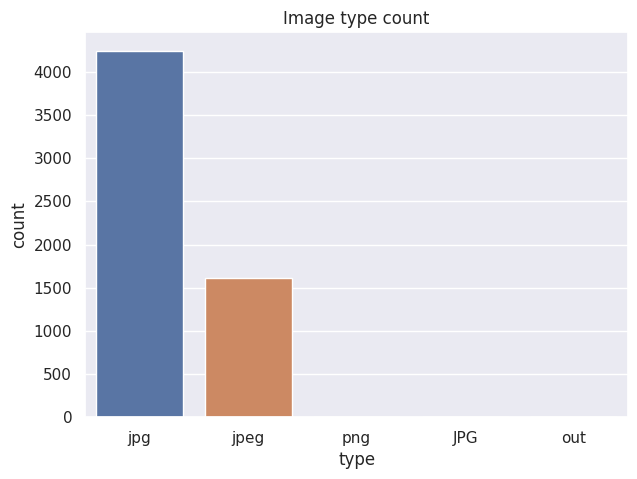

In [10]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
sns.countplot(data =df, x='type')
plt.title('Image type count')
df['type'].value_counts()

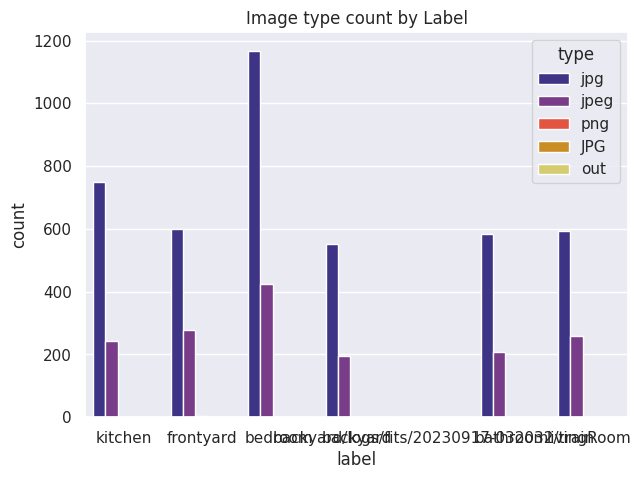

In [11]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
sns.countplot(data =df, x='label',hue ='type', palette="CMRmap")
plt.title('Image type count by Label')
plt.show()

In [12]:
# # Extracting height and width of images for analysis
# height, width = [], []
# for image in tqdm(df['path'].values):
#   img = cv2.imread(image)
#   height.append(img.shape[0])
#   width.append(img.shape[1])

In [13]:
# # Height analysis
# plt.figure(figsize=(7,5))
# plt.title('PDF of Image height')
# sns.set_theme(style="darkgrid")
# sns.distplot(height, hist= True)

# for i in range(10,101,10):
#   print("{}% images has height {}".format(i,np.percentile(height,i)))

In [14]:
# # Width analysis
# plt.figure(figsize=(7,5))
# plt.title('PDF of Image width')
# sns.set_theme(style="darkgrid")
# sns.distplot(width)

# for i in range(10,101,10):
#   print("{}% images has width {}".format(i,np.percentile(width,i)))

In [15]:
# # visualizing 4 random images from all the classes
# fig, ax = plt.subplots(6, 4)
# fig.set_size_inches(20,20)
# fig.tight_layout()
# for i in range(len(ax)):
#   row = ax[i]
#   label = df['label'].unique()[i]
#   temp_df = df[df['label'] == label]
#   for col in row:
#     num = np.random.randint(0,len(temp_df.values))
#     Image = cv2.imread(temp_df.values[num][0])
#     col.imshow(Image)
#     col.axis('off')
#     col.set_title(label)

In [12]:
msk = np.random.rand(len(df)) < 0.8
X_train = df[msk]
X_test = df[~msk]

In [13]:
#Image Augmentation
datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5),
        )

datagen_test = ImageDataGenerator(rescale=1./255)


train_generator=datagen_train.flow_from_dataframe(
    X_train, x_col='path',
    y_col='label',
    class_mode="categorical",
    target_size=(224,224),
    batch_size=32)

test_generator=datagen_test.flow_from_dataframe(
    X_test, x_col='path',
    y_col='label',
    class_mode="categorical",
    target_size=(224,224),
    batch_size=32)

Found 4711 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 1148 validated image filenames belonging to 6 classes.


In [18]:
# # Baseline Model
# model = Sequential()
# model.add(Conv2D(64, (3, 3), padding='same',
#                  input_shape=(224,224,3)))
# model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(32, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(16, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(6, activation='softmax'))
# model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])
# model.summary()

In [19]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# import datetime
# %load_ext tensorboard
# log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/baseline_weights.h5', save_weights_only=True, save_best_only=True, \
#                                        mode='max', monitor='val_accuracy'),
#             tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

# model.fit(train_generator,
#           steps_per_epoch=STEP_SIZE_TRAIN,
#           validation_data=test_generator,
#           validation_steps=STEP_SIZE_TEST,
#           callbacks = callbacks,
#           epochs = 20)

In [20]:
# # resume traning from previous last epoch
# model.fit(train_generator,
#           steps_per_epoch=STEP_SIZE_TRAIN,
#           validation_data=test_generator,
#           validation_steps=STEP_SIZE_TEST,
#           callbacks = callbacks,
#           epochs = 20)

In [21]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# baseline_model.evaluate_generator(generator=test_generator)

In [22]:
# n_batches = len(test_generator)
# y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
# predict  = np.argmax(baseline_model.predict_generator(test_generator, steps=n_batches), axis=1)

# vocab_dict = (train_generator.class_indices)
# plot_confusion_matrix(y_true, predict)

---

In [23]:
# !rm -rf ./logs/

# resnet_layer = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling=None,
#     classes=6,
#     classifier_activation="softmax",
# )

# faltten_layer = Flatten()(resnet_layer.output)
# fc1 = Dense(256,activation='relu')(faltten_layer)

# output_layer = Dense(6,activation='softmax')(fc1)

# for layer in resnet_layer.layers:
#   layer.trainable = False

# resnet_1 = Model(resnet_layer.input,output_layer)
# resnet_1.compile(optimizer= "Adam",loss='CategoricalCrossentropy', metrics=['accuracy'])
# resnet_1.summary()

In [24]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# import datetime
# %load_ext tensorboard

# log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
# callbacks = [tf.keras.callbacks.ModelCheckpoint(saved_model_fp, save_weights_only=True, save_best_only=True, \
#                                        mode='max', monitor='val_accuracy'),
#             tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

# resnet_1.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=test_generator,
#                     validation_steps=STEP_SIZE_TEST,
#                     callbacks=callbacks,
#                     epochs=20)

In [25]:
# os.chdir("/content/drive/MyDrive/Colab Notebooks/HackMIT/REI-Dataset/backyard/")
# !ls

In [26]:
# # serialize model to JSON
# model_json = resnet_1.to_json()
# with open(saved_model_fp, "w") as json_file:
#     json_file.write(model_json)

In [27]:
# with open(saved_model_fp, "r") as json_file:
#     resnet_1 = json_file.read()
# resnet_1 = tf.keras.models.model_from_json(resnet_1)
# resnet_1.load_weights(saved_model_fp)
# resnet_1.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [28]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# resnet_1.evaluate_generator(generator=test_generator)

In [29]:
# n_batches = len(test_generator)
# y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
# predict  = np.argmax(resnet_1.predict_generator(test_generator, steps=n_batches), axis=1)

# vocab_dict = (train_generator.class_indices)
# plot_confusion_matrix(y_true, predict)

---

In [30]:
# !rm -rf ./logs/

# resnet_layer = resnet_layer = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling=None,
#     classes=6,
#     classifier_activation="softmax",
# )

# conv_layer = tf.keras.layers.Conv2D(64,kernel_size=(7,7),activation='relu')(resnet_layer.output)
# conv_layer2 = tf.keras.layers.Conv2D(32,kernel_size=(1,1),activation='relu')(conv_layer)

# faltten_layer = Flatten()(conv_layer2)
# fc1 = Dense(128,activation='relu')(faltten_layer)
# fc2 = Dense(64,activation='relu')(fc1)

# output_layer = Dense(6,activation='softmax')(fc2)

# for layer in resnet_layer.layers[:143]:
#   layer.trainable = False

# resnet_2 = Model(resnet_layer.input,output_layer)
# resnet_2.compile(optimizer= "Adam",loss='CategoricalCrossentropy', metrics=['accuracy'])
# resnet_2.summary()

In [14]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet',
    # base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',
                                include_top=False,
                                # classes=6,
                                # classifier_activation="softmax",
                                input_shape=(224,224,3))
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output

# Add new layers to the end of the base model
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

predictions = Dense(6, activation="softmax")(x)

resnet_2 = Model(inputs=base_model.inputs, outputs=predictions)

94668760/94668760 [==============================] - 0s 0us/step


In [15]:
METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

from tensorflow.keras.optimizers import Adam

resnet_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=METRICS)

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard

logs = r'/content/drive/MyDrive/Colab Notebooks/HackMIT/logs'
log_dir = os.path.join(logs,'fit', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
callbacks = [tf.keras.callbacks.ModelCheckpoint(saved_model_fp, save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

# resnet_2.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=test_generator,
#                     validation_steps=STEP_SIZE_TEST,
#                     callbacks=callbacks,
#                     epochs=20)

history = resnet_2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

Epoch 1/20
147/147 [==============================] - 1654s 11s/step - loss: 0.4943 - accuracy: 0.8171 - precision: 0.8413 - recall: 0.7944 - val_loss: 0.3239 - val_accuracy: 0.8786 - val_precision: 0.8809 - val_recall: 0.8714 - lr: 0.0010
Epoch 2/20
147/147 [==============================] - 96s 654ms/step - loss: 0.3083 - accuracy: 0.8807 - precision: 0.8906 - recall: 0.8733 - val_loss: 0.2807 - val_accuracy: 0.9018 - val_precision: 0.9055 - val_recall: 0.8982 - lr: 0.0010
Epoch 3/20
147/147 [==============================] - 96s 653ms/step - loss: 0.2749 - accuracy: 0.8968 - precision: 0.9049 - recall: 0.8904 - val_loss: 0.2374 - val_accuracy: 0.9170 - val_precision: 0.9209 - val_recall: 0.9143 - lr: 0.0010
Epoch 4/20
147/147 [==============================] - 100s 677ms/step - loss: 0.2461 - accuracy: 0.9060 - precision: 0.9136 - recall: 0.8991 - val_loss: 0.2439 - val_accuracy: 0.9134 - val_precision: 0.9155 - val_recall: 0.9089 - lr: 0.0010
Epoch 5/20
147/147 [===================

In [17]:
model_filepath = r'/content/drive/MyDrive/Colab Notebooks/HackMIT/saved_models/resnet50v2_20-EPOCHS_v2'
resnet_2.save(model_filepath)

In [18]:
json_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/HackMIT/saved_models/resnet50v2_20-EPOCHS_v2.json'
# resnet_2.save_model(model_filepath)

model_json = resnet_2.to_json()
with open(json_model_filepath, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
final_model_fp = r'/content/drive/MyDrive/Colab Notebooks/HackMIT/saved_models/resnet50v2_20-EPOCHS_v2.h5'
resnet_2.save_weights(final_model_fp)
print("Saved model to disk")

Saved model to disk


In [19]:
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)

    # I hand calculated F1-score since tfa's caused errors
    f1_scores = []
    # calculate f1-score from precision and recall
    for i in range(len(history.history['val_recall'])):
        if history.history['val_precision'][i] != 0 and history.history['val_recall'][i] != 0:
            f1_scores.append((2 * history.history['val_precision'][i] * history.history['val_recall'][i]) / (history.history['val_precision'][i] + history.history['val_recall'][i]))

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

        if metric is not 'loss':
            non_zeros = [num for num in history.history['val_' + metric] if num != 0]
            avg = "{:.4f}".format(np.mean(non_zeros))
            std = "{:.4f}".format(np.std(non_zeros))
            se = "{:.4f}".format(float(std) / (test_generator.n) ** 0.5)
            print(metric + ': {} ± {}'.format(avg, se))

    # print f1-score
    f1_score = "{:.4f}".format(f1_scores[-1])
    avg = "{:.4f}".format(np.mean(f1_scores))
    std = "{:.4f}".format(np.std(f1_scores))
    se = "{:.4f}".format(float(std) / (test_generator.n) ** 0.5)
    print('final f1-score: ' + f1_score)
    print('f1-score' + ': {} ± {}'.format(avg, se))

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-19-5f2b4a3418a4>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if metric is not 'loss':


accuracy: 0.9133 ± 0.0004
precision: 0.9159 ± 0.0004
recall: 0.9106 ± 0.0004
final f1-score: 0.9267
f1-score: 0.9132 ± 0.0004


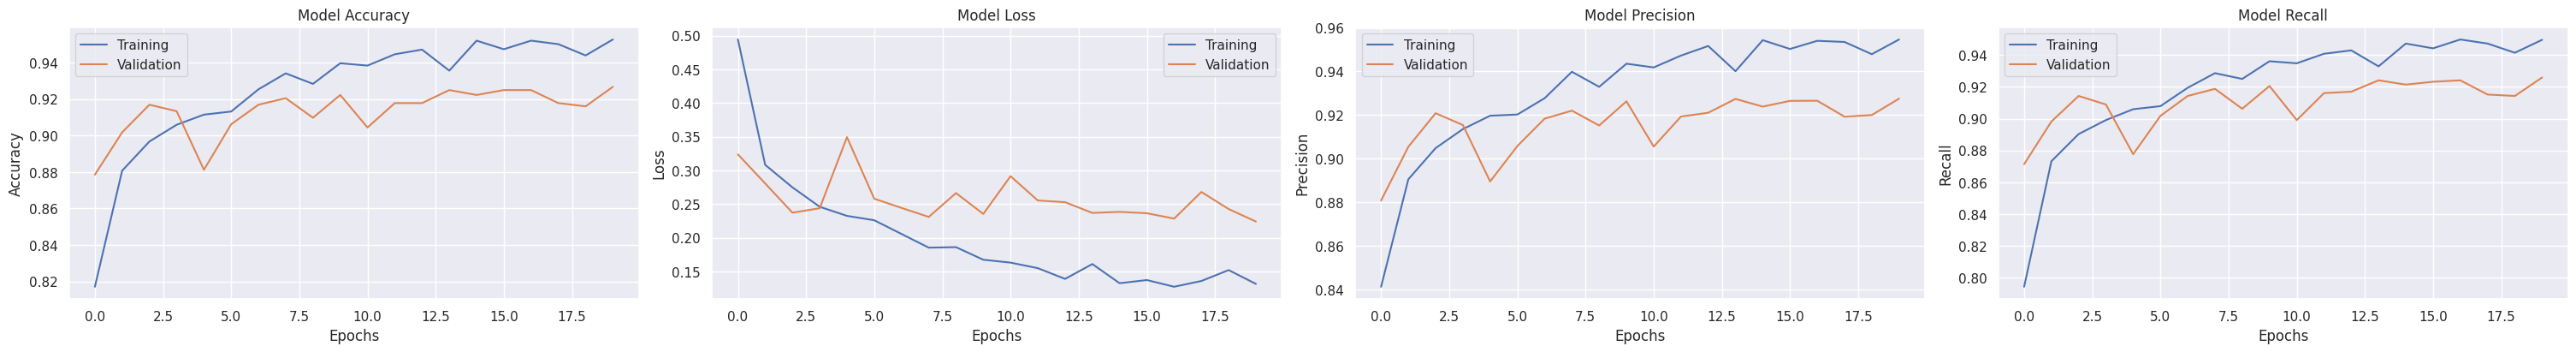

In [20]:
evaluate_model(history)

In [39]:
# # serialize model to JSON
# model_json = resnet_2.to_json()
# with open(saved_model_fp, "w") as json_file:
#     json_file.write(model_json)
# with open(saved_model_fp, "r") as json_file:
#     resnet_2 = json_file.read()
# resnet_2 = tf.keras.models.model_from_json(resnet_2)
# resnet_2.load_weights(saved_model_fp)
# resnet_2.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# resnet_2.evaluate_generator(generator=test_generator)


# serialize model to JSON
# model_json = resnet_2.to_json()


# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

In [22]:
def plot_confusion_matrix(data_generator, predictions):
    cm = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['backyard', 'bathroom', 'bedroom', 'frontyard', 'kitchen', 'living_room'])

    # cm_display.plot(include_values=True,
    #                 cmap='Blues',
    #                 xticks_rotation=45,
    #                 values_format='.5g')

    cm_display.plot()

    plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
                                              'color' : 'black',
                                              'weight': 'heavy',
                                              'size'  :  12})
    # plt.tick_params(axis=u'both', which=u'both',length=0)
    # plt.grid(b=None)

    plt.show()

In [23]:
def plot_precision_recall(data_generator, predictions, ax):
    precision, recall, thresholds = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions)
    average_precision = average_precision_score(y_true=data_generator.labels, y_score=predictions)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name=None)

    pr_display.plot(ax=ax, name='Proposed Model')

    ax.set_title('Precision Recall Curve', fontdict = {'family': 'DejaVu Sans',
                                                       'color' : 'black',
                                                       'weight': 'heavy',
                                                       'size'  :  12})

In [24]:
def plot_roc_curve(data_generator, predictions, ax):
    ns_predictions = [0 for i in range(data_generator.n)]

    ns_auc = roc_auc_score(y_true=data_generator.labels, y_score=ns_predictions)
    auc = roc_auc_score(y_true=data_generator.labels, y_score=predictions)

    ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_true=testing_generator.labels, y_score=ns_predictions)
    fpr, tpr, thresholds = roc_curve(y_true=testing_generator.labels, y_score=predictions)

    ax.plot(fpr, tpr, marker='.', label='Proposed Model (AUC = %0.3f)' % auc)
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = %0.3f)' % ns_auc)

    ax.set_title('ROC Curve', fontdict = {'family': 'DejaVu Sans',
                                         'color' : 'black',
                                         'weight': 'heavy',
                                         'size'  :  12})
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

In [ ]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
# predict  = np.argmax(resnet_2.predict_generator(test_generator, steps=n_batches), axis=1)

predict = resnet_2.predict(test_generator, verbose=1)
# rounded_predictions = np.around(predict.copy()).astype(int)
rounded_predictions = np.argmax(predict.copy(), axis=1)

vocab_dict = (train_generator.class_indices)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_roc_curve(test_generator, predict, ax1)
plot_precision_recall(test_generator, predictions, ax2)

# cm = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=predict)
# cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['backyard', 'bathroom', 'bedroom', 'frontyard', 'kitchen', 'living_room'])

plot_confusion_matrix(test_generator, rounded_predictions)

# cm_display.plot()
                    # include_values=True,
                    # cmap='Blues',
                    # xticks_rotation=45,
                    # values_format='.5g')

# plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
#                                           'color' : 'black',
#                                           'weight': 'heavy',
#                                           'size'  :  12})
# plt.tick_params(axis=u'both', which=u'both',length=0)
# plt.grid(b=None)

# plt.show()

In [ ]:
!pip install scikit-learn==scikit-learn 0.23.2
from sklearn.metrics import plot_confusion_matrix

n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(resnet_2.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

In [50]:
sklearn.__version__

'1.2.2'

In [43]:
model = load_model(model_filepath)

In [45]:
test_fp = r'/content/drive/MyDrive/Colab Notebooks/HackMIT/REI-Dataset/bedroom/bedroom (1009).jpg'
resized_img = np.asarray(resize(cv2.imread(test_fp), (224, 224))).astype(np.uint8)
np.seterr(divide='ignore', invalid='ignore')
resized_img = resized_img / 255

testing_img = resized_img.reshape(1, 224, 224, 3)
prediction = model.predict(testing_img)
print(prediction)

1/1 [==============================] - 0s 29ms/step
[[5.3836058e-05 2.2085711e-04 9.2606759e-01 1.5787580e-05 4.7533318e-05
  7.3594473e-02]]


---